<a href="https://colab.research.google.com/github/Masakinka/Bank-Customer-Churn-Prediction-Project/blob/main/01_Logistic_Regression_with_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project Overview

This project aims to build a machine learning model for predicting customer churn in the banking sector, using the dataset provided by the Kaggle competition, **[Bank Customer Churn Prediction (DLU Course)](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu)**. The goal is to apply logistic regression as the primary method for solving this classification problem.

We will begin by loading the relevant datasets: `train.csv`, `test.csv`, and `sample_submission.csv`, which are provided as part of the competition. The task involves preprocessing the data, training the model, and submitting the predictions on the test set.

### Feature Description

The dataset contains the following features:

| Feature          | Description                                      | Data Type  |
|------------------|--------------------------------------------------|------------|
| `id`             | Unique identifier for each customer               | Numerical  |
| `CustomerId`     | Customer identification number                    | Numerical  |
| `Surname`        | Customer surname                                  | Categorical|
| `CreditScore`    | Credit score of the customer                      | Numerical  |
| `Geography`      | Customer's country of residence                   | Categorical|
| `Gender`         | Customer gender                                   | Categorical|
| `Age`            | Customer age                                      | Numerical  |
| `Tenure`         | Number of years with the bank                     | Numerical  |
| `Balance`        | Account balance                                   | Numerical  |
| `NumOfProducts`  | Number of bank products the customer is using     | Numerical  |
| `HasCrCard`      | Whether the customer has a credit card (1/0)      | Binary     |
| `IsActiveMember` | Whether the customer is an active member (1/0)    | Binary     |
| `EstimatedSalary`| Customer's estimated annual salary                | Numerical  |
| `Exited`         | Whether the customer churned (target variable)    | Binary     |

### Problem Statement

The objective of this project is to build a binary classification model that predicts whether a customer will churn (exit the bank) based on their demographics, financial status, and banking behavior.

### Key Project Goals

1. Develop a robust logistic regression model to predict customer churn.
2. Identify key factors contributing to customer churn.
3. Provide actionable insights for improving customer retention strategies.

### Scope and Limitations

- The model uses historical data and does not update in real-time.
- The dataset provided is pre-cleaned, with no missing values.
- The analysis will not differentiate between various customer segments.

### Main Objective

The main objective is to develop a predictive model to help the bank identify customers at risk of leaving and to improve retention efforts through targeted interventions.


## Directory Cleaner (Optional)
The commented-out section of code is designed to clean up the directory. It checks if a specific directory exists and removes it along with all its contents if found. This is useful for ensuring that the environment is clean before starting any operations, especially in iterative workflows.

Check if a specific directory exists and delete it if it does. This is useful to start with a fresh working directory.

In [2]:
# # directory cleaner
# import shutil
# directory = './bank-customer-churn-prediction-dlu'
# # Check if the directory exists
# if os.path.exists(directory):
#     # Remove the directory and all its contents
#     shutil.rmtree(directory)
#     print(f"Directory {directory} has been cleared.")
# else:
#     print(f"Directory {directory} does not exist.")

## Installing Necessary Libraries

These two lines install additional Python packages that are not necessarily included in standard environments:

- opendatasets: This package is used to download datasets from Kaggle directly using the Kaggle API.
- pyarrow: It provides efficient support for reading and writing data in Parquet format, commonly used for data storage.

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
!pip install pyarrow --quiet

**Importing Libraries**

In [5]:
import opendatasets as od
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score

Here we customize the display settings for pandas to ensure that large dataframes are fully visible when printed. It allows us to view up to 130 rows and columns at a time, formats floating-point numbers to two decimal places, and displays all columns without truncating the view.

In [6]:
pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [7]:
od.version()

'0.1.22'

## Loading Dataset

We define the URL for the Kaggle competition from which we need to download the dataset. The opendatasets library is used to download the dataset to the local directory. It will prompt for the user's Kaggle credentials (username and API key).

In [8]:
# URL of the Kaggle competition dataset
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/'

# Downloading and extracting the dataset using opendatasets
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: viktoriiabortnikova
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 47.5MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


We check the directory to ensure that the dataset files have been downloaded successfully. Then, we load the training data from train.csv into a pandas DataFrame for further analysis. This data contains information about customer churn from the bank.

In [11]:
# Defining the directory where the dataset is stored
data_dir = './bank-customer-churn-prediction-dlu'

# Listing the files in the directory to confirm the download
os.listdir(data_dir)
# Expected files: 'train.csv', 'test.csv', 'sample_submission.csv'

['train.csv', 'test.csv', 'sample_submission.csv']

In [12]:
# define train_csv
train_csv = data_dir + '/train.csv'

In [14]:
# Loading the training data into a pandas DataFrame
raw_df = pd.read_csv(train_csv)
raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.00,Nwankwo,678.00,France,Male,29.00,4.00,0.00,3.00,1.00,0.00,180626.36,0.00
1,1,15650086.00,Ch'in,687.00,France,Female,34.00,1.00,0.00,2.00,0.00,1.00,63736.17,0.00
2,2,15733602.00,Thompson,682.00,France,Female,52.00,6.00,0.00,3.00,0.00,0.00,179655.87,1.00
3,3,15645794.00,Macleod,753.00,Germany,Male,44.00,6.00,83347.25,2.00,1.00,0.00,161407.48,0.00
4,4,15633840.00,Hsia,544.00,Germany,Female,55.00,0.00,107747.57,1.00,1.00,0.00,176580.86,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.00,Ch'iu,585.00,France,Male,33.00,3.00,0.00,1.00,1.00,0.00,54191.38,0.00
14996,14996,15731781.00,Ch'ang,678.00,France,Male,34.00,6.00,0.00,2.00,1.00,1.00,53437.10,0.00
14997,14997,15667093.00,Goliwe,678.00,France,Female,54.00,4.00,0.00,1.00,1.00,0.00,147720.29,1.00
14998,14998,15732644.00,Fanucci,705.00,Spain,Female,40.00,7.00,0.00,2.00,1.00,0.00,149550.95,0.00


## Exploratory Data Analysis (EDA)
We begin by exploring the dataset:

- info(): Provides a concise summary of the DataFrame, including data types, missing values, and memory usage.
- describe(): Generates descriptive statistics for numerical columns.
- Checking for Missing Values: We check if any of the columns contain missing values.

In [15]:
# Checking the basic information of the dataset
raw_df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [16]:
# Generating descriptive statistics for numerical columns
raw_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,7499.50,15691456.68,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67,0.20
std,4330.27,135205.03,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45,0.40
min,0.00,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,3749.75,15635143.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14,0.00
50%,7499.50,15690175.00,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87,0.00
75%,11249.25,15757181.50,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70,0.00
max,14999.00,15815690.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48,1.00


In [17]:
# Checking for missing values in the dataset
raw_df.isna().sum()

,0
id,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


**Data Quality Check**


We perform a check to ensure that columns such as Age, CreditScore, CustomerId, etc., do not contain fractional values when they are expected to hold integer values.

In [18]:
# check for fractional results in these columns
fractional_values_check = {
    'Age': raw_df[raw_df['Age'] % 1 != 0].shape[0],
    'CreditScore':  raw_df[raw_df['CreditScore'] % 1 != 0].shape[0],
    'CustomerId':  raw_df[raw_df['CustomerId'] % 1 != 0].shape[0],
    'Tenure': raw_df[raw_df['Tenure'] % 1 != 0].shape[0],
    'NumOfProducts': raw_df[raw_df['NumOfProducts'] % 1 != 0].shape[0],
    'HasCrCard': raw_df[raw_df['HasCrCard'] % 1 != 0].shape[0],
    'IsActiveMember': raw_df[raw_df['IsActiveMember'] % 1 != 0].shape[0],
    'Exited': raw_df[raw_df['Exited'] % 1 != 0].shape[0],
}
fractional_values_check

{'Age': 0,
 'CreditScore': 0,
 'CustomerId': 0,
 'Tenure': 0,
 'NumOfProducts': 0,
 'HasCrCard': 0,
 'IsActiveMember': 0,
 'Exited': 0}

We correct the data types for certain columns to ensure consistency and to avoid issues later in the pipeline. For example, we convert CustomerId, CreditScore, Age, etc., from floating-point values to integers.

In [19]:
# Correct data types
raw_df['CustomerId'] = raw_df['CustomerId'].astype(int)
raw_df['CreditScore'] = raw_df['CreditScore'].astype(int)
raw_df['Age'] = raw_df['Age'].astype(int)
raw_df['Tenure'] = raw_df['Tenure'].astype(int)
raw_df['Exited'] = raw_df['Exited'].astype(int)
raw_df['NumOfProducts'] = raw_df['NumOfProducts'].astype(int)
raw_df['HasCrCard'] = raw_df['HasCrCard'].astype(int)
raw_df['IsActiveMember'] = raw_df['IsActiveMember'].astype(int)

**Splitting Data into Training and Validation Sets**


Here, we split the dataset into features (X) and target (y). We then use train_test_split with stratification to create training and validation datasets. Stratification ensures that the target variable's distribution is the same in both the training and validation sets, which is especially important when working with imbalanced datasets (like customer churn).

In [20]:
# Split the data into features and target
X = raw_df.drop('Exited', axis=1)
y = raw_df['Exited']

# Split the data into training and validation sets with stratification
# This parameter indicates that the data split should be stratified according to the variable y.
# This means that the distribution of classes in the training and validation sets will be similar
# to the distribution of classes in the original dataset. This is important if you have imbalanced classes.
# train_val_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Display the shapes of the splits
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")

# Display the first few rows of the training set
print(X_train.head())
print(y_train.head())

Training set shape: (12000, 13), (12000,)
Validation set shape: (3000, 13), (3000,)
          id  CustomerId    Surname  CreditScore Geography  Gender  Age  Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary
7180    7180    15652218       Mays          682    France    Male   30       1 131394.56              1          1               1        143952.24
10393  10393    15592937     Ch'eng          684    France  Female   39       2 178058.06              1          1               0        145518.31
80        80    15774586      Ch'in          705   Germany    Male   35       6 116320.68              2          1               0        174431.01
3365    3365    15780572         K?          669     Spain    Male   58       0      0.00              2          0               1         51565.98
12236  12236    15642099  Trevisani          707    France    Male   21       3      0.00              2          1               1        148564.76
7180     0
10393    0


`Customer ID`: A unique identifier for each customer (this field contains duplicates for different customer information, so we simply remove it).


## Checking for Unique Users


We perform some additional analysis by checking the uniqueness of the Surname and CustomerId columns in the train and validation sets. This helps us understand how many unique customers we have in each dataset.

**Check for unique users based on 'Surname'**

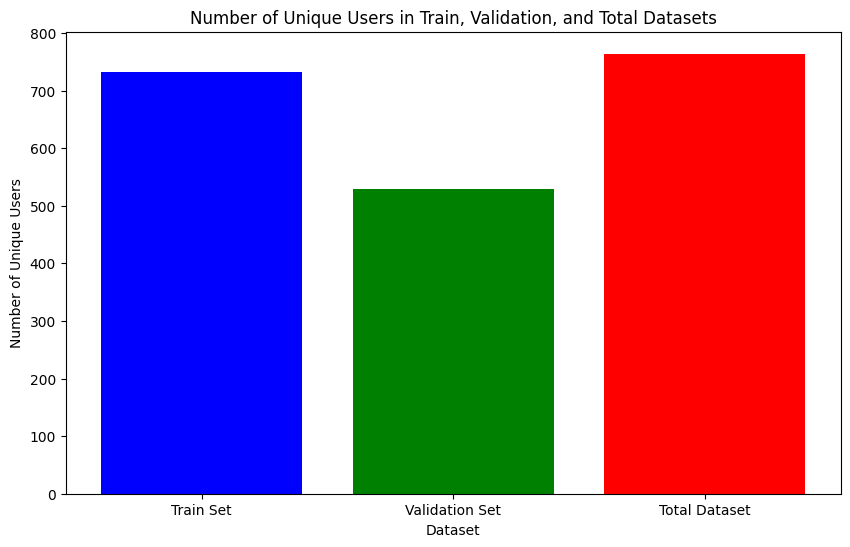

In [21]:
# Check for unique users based on 'Surname'
train_unique_users = X_train['Surname'].nunique()
val_unique_users = X_val['Surname'].nunique()
total_unique_users = raw_df['Surname'].nunique()

# Create a bar plot
labels = ['Train Set', 'Validation Set', 'Total Dataset']
unique_users_counts = [train_unique_users, val_unique_users, total_unique_users]

plt.figure(figsize=(10, 6))
plt.bar(labels, unique_users_counts, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users in Train, Validation, and Total Datasets')
plt.show()

- The training dataset contains around 5700 unique surnames.
- The validation set has fewer unique surnames, indicating that some surnames are repeated across different subsets.
- Overall, the total dataset has 6348 unique surnames, showing that some customers are listed multiple times due to varying information.

**Check for unique users based on 'CustomerId'**

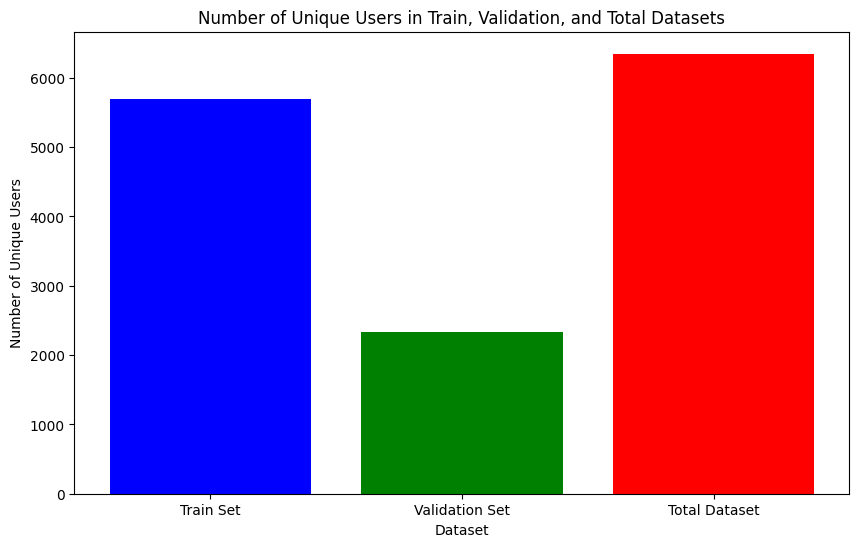

In [22]:
# Check for unique users based on 'CustomerId'
train_unique_users = X_train['CustomerId'].nunique()
val_unique_users = X_val['CustomerId'].nunique()
total_unique_users = raw_df['CustomerId'].nunique()

# Create a bar plot
labels = ['Train Set', 'Validation Set', 'Total Dataset']
unique_users_counts = [train_unique_users, val_unique_users, total_unique_users]

plt.figure(figsize=(10, 6))
plt.bar(labels, unique_users_counts, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users in Train, Validation, and Total Datasets')
plt.show()

- The total number of unique CustomerId values is 6348, which means that this field can help us uniquely identify customers in the dataset.
- There is a similar pattern between the train and validation sets when we examine the CustomerId column, with fewer unique IDs in the validation set.
- Based on this observation, we will drop the CustomerId column since it doesn't contribute meaningfully to the prediction task and might introduce data leakage due to repetition.

In [23]:
train_unique_users,val_unique_users,total_unique_users

(5700, 2327, 6348)

#### Summary of Unique Users:
- **Train Set:** 5700 unique users based on `Surname`.
- **Validation Set:** 2327 unique users based on `Surname`.
- **Total Dataset:** 6348 unique users in total.

This shows that there is some overlap between the train and validation sets, but overall, the `Surname` column provides a significant number of unique identifiers for customers across the dataset.


### 2. Define Input and Target Columns
Next, we identify the input (independent) columns for the features and the target column for prediction. These will be stored in `input_cols` and `target_col`, respectively.

In the previous task, the `train_test_split` method was used with the `stratify` parameter, which ensures that the distribution of the target variable (`Exited`) remains consistent across the training and validation sets. Therefore, we no longer need to explicitly define the input columns and target column to perform the split.


In [24]:
# Uncomment if manual column selection is needed
#input_cols = list(X_train.columns)[1:-1]
#target_col = 'Exited'

We proceed to create datasets for training and validation:

- train_inputs: Training feature data.
- train_targets: Training target data (Exited).
- val_inputs: Validation feature data.
- val_targets: Validation target data (Exited).

In [25]:
# Create the specified datasets
train_inputs = X_train.copy()
train_targets = y_train.copy()
val_inputs = X_val.copy()
val_targets = y_val.copy()

By copying the original splits into these new variables, we ensure our data is ready for further processing without altering the original data structures. This step is crucial for maintaining the integrity of the training and validation data during preprocessing.

### 3. Identifying Numerical and Categorical Columns
In this step, we will use `pandas.DataFrame.select_dtypes` to differentiate between numerical and categorical columns in our dataset. The identified columns will be stored in two separate lists: `numeric_cols` for numerical features and `categorical_cols` for categorical features.

In [26]:
# Identifying numerical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
# Identifying categorical columns
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Displaying the results
numeric_cols, categorical_cols

(['id',
  'CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

Now that we’ve identified the numerical columns, let’s generate summary statistics using the describe() method to understand the distribution of each numerical feature. We round the values to two decimal places for better readability.

In [27]:
# Generating summary statistics for the numerical columns
train_inputs[numeric_cols].describe().round(2)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,7479.63,15690923.99,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,4334.09,146930.97,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,0.00,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,3725.75,15635116.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,7471.50,15689953.00,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,11231.25,15756921.50,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,14999.00,15815690.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


For the categorical columns, it’s important to understand how many unique values each column contains. This will help determine how to handle them during the preprocessing stage (e.g., using one-hot encoding for low cardinality or ignoring high-cardinality columns).

In [28]:
# Counting unique values in categorical columns
train_inputs[categorical_cols].nunique()

,0
Surname,732
Geography,3
Gender,2



### Key Observations:
- The **'Surname'** column has a high number of unique values (732). This may require special handling as encoding a large number of categories could lead to overfitting.
- The **'Geography'** and **'Gender'** columns have only 3 and 2 unique values, respectively, making them good candidates for one-hot encoding.

These insights will guide the feature engineering and preprocessing steps that follow.


## 4. Data Preprocessing for Numerical and Categorical Columns
To prepare the data for input into the model, we will preprocess both numerical and categorical columns. The following steps will be taken:

- Scaling numerical features to ensure they are on the same scale,
- Encoding categorical features for compatibility with machine learning algorithms,
- Removing irrelevant features or those that do not contribute to model performance.

The preprocessing will be applied consistently to both training and validation datasets to ensure the model performs well on unseen data.


 We will not work on filling in the missing values, since at the analysis stage we verified that there are no such values.

**Visualizing the Distribution of Numerical Features**

Before proceeding with preprocessing, it is important to understand the distribution of the numerical features. This will help identify potential outliers and determine the need for scaling.

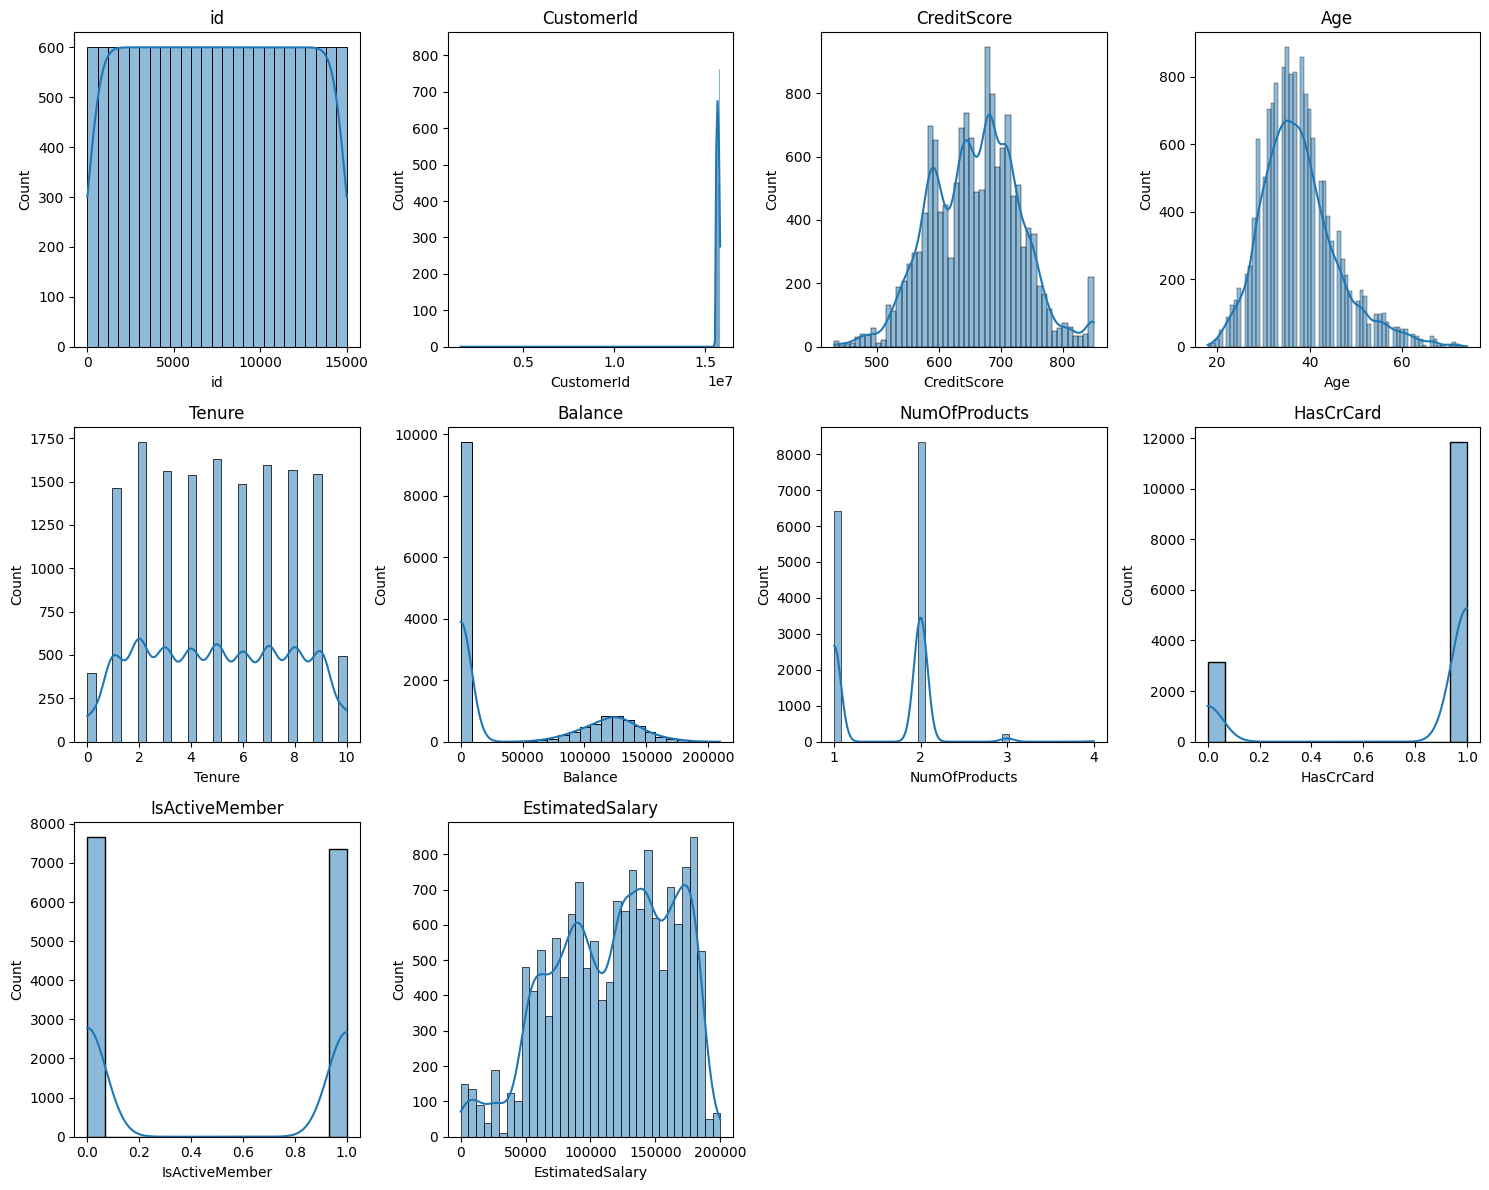

In [29]:
# Visualization of numerical data distribution
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 4, i + 1)
    sns.histplot(raw_df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

Analysis of the Visualizations:
- ID and CustomerID: These columns are unique identifiers and will be excluded from the model, as they do not provide predictive value.
- CreditScore: Exhibits a normal distribution, suggesting minimal transformation is needed apart from scaling.
- Age: Skewed slightly toward younger customers, but remains within a reasonable range.
- Tenure: Distributed fairly uniformly, which indicates customers have a wide range of tenure lengths.
- Balance: Highly skewed with a large number of customers having zero balance. This may impact the model and will require scaling.
- NumOfProducts: Most customers hold 1 or 2 products, with fewer customers holding 3 or more. The feature is categorical but will benefit from encoding.
- HasCrCard and IsActiveMember: These are binary variables and will be encoded appropriately.
- EstimatedSalary: Normally distributed, but with some outliers, suggesting the need for scaling to standardize the feature

**Categorical Data Distribution and Visualization**

In this section, we analyze the distribution of categorical features present in the dataset: Surname, Geography, and Gender. Understanding the distribution of categorical features is essential as it gives us insights into the composition of the dataset and helps identify any imbalances or patterns that may affect model performance. We will also visualize these distributions to get a clearer view of the frequency of different categories.


We first use `value_counts() `to display the unique values and their counts for each feature.
This allows us to check for possible imbalances that may need to be addressed, particularly for features like `Geography` and `Gender`.



In [30]:
# Analysis of categorical data
for col in categorical_cols:
    print(f"Distribution of values in the column {col}: {col}:")
    print(raw_df[col].value_counts())

Distribution of values in the column Surname: Surname:
Surname
Ch'iu      252
Ch'ien     241
Ch'ang     225
Hsia       204
T'ien      187
          ... 
Trejo        1
Purdy        1
Otoole       1
Sarratt      1
Liardet      1
Name: count, Length: 764, dtype: int64
Distribution of values in the column Geography: Geography:
Geography
France     9032
Spain      3303
Germany    2665
Name: count, dtype: int64
Distribution of values in the column Gender: Gender:
Gender
Male      8529
Female    6471
Name: count, dtype: int64


- `Surname`: The distribution of surnames is highly uneven, with some surnames appearing very frequently and many others appearing only once or a few times. This feature is not likely to be informative for prediction and may lead to overfitting if not properly handled.
- `Geography`: Most customers are from France, followed by Spain and Germany. The imbalance in geographical distribution could affect the model's performance if not addressed.
- `Gender`: There are more male customers than female customers, but the difference
is not as significant as in geography.

Using bar plots for each categorical feature helps us visualize the count of occurrences for each category.
This is particularly useful for identifying class imbalances, which may need to be addressed during model training.

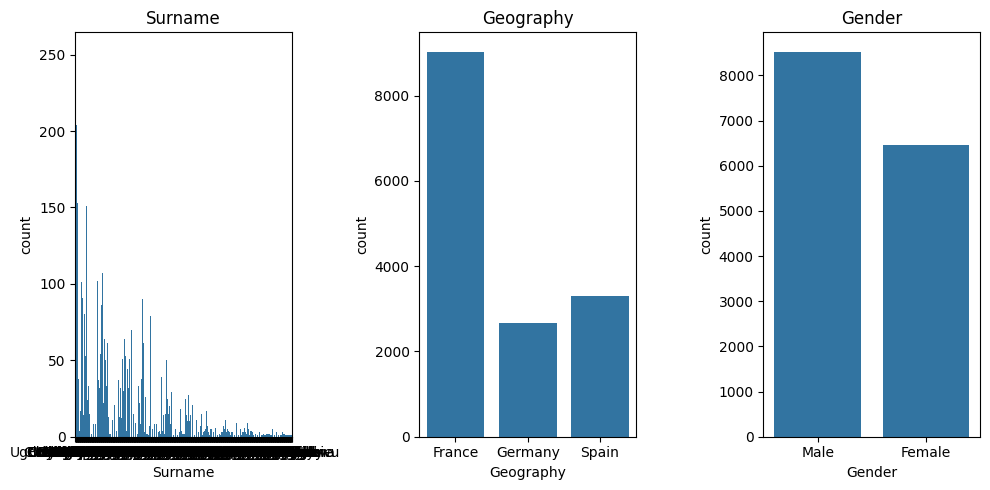

In [31]:
# Visualization of categorical data distribution
plt.figure(figsize=(10, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=raw_df, x=col)
    plt.title(col)
plt.tight_layout()
plt.show()

By analyzing and visualizing categorical data, we can make informed decisions about how to handle these features during preprocessing. Based on the analysis, we may decide to:
- Drop the `Surname` feature, as it seems unlikely to contribute to the prediction task.
- Encode the `Geography` and `Gender` features using one-hot encoding to ensure the model can properly interpret them.

**Data Analysis: Correlation between Features and Target Variable**

In this section, we conduct a detailed analysis of how numerical and categorical features in the dataset correlate with the target variable `Exited`. This helps identify which features might play an important role in predicting customer churn.


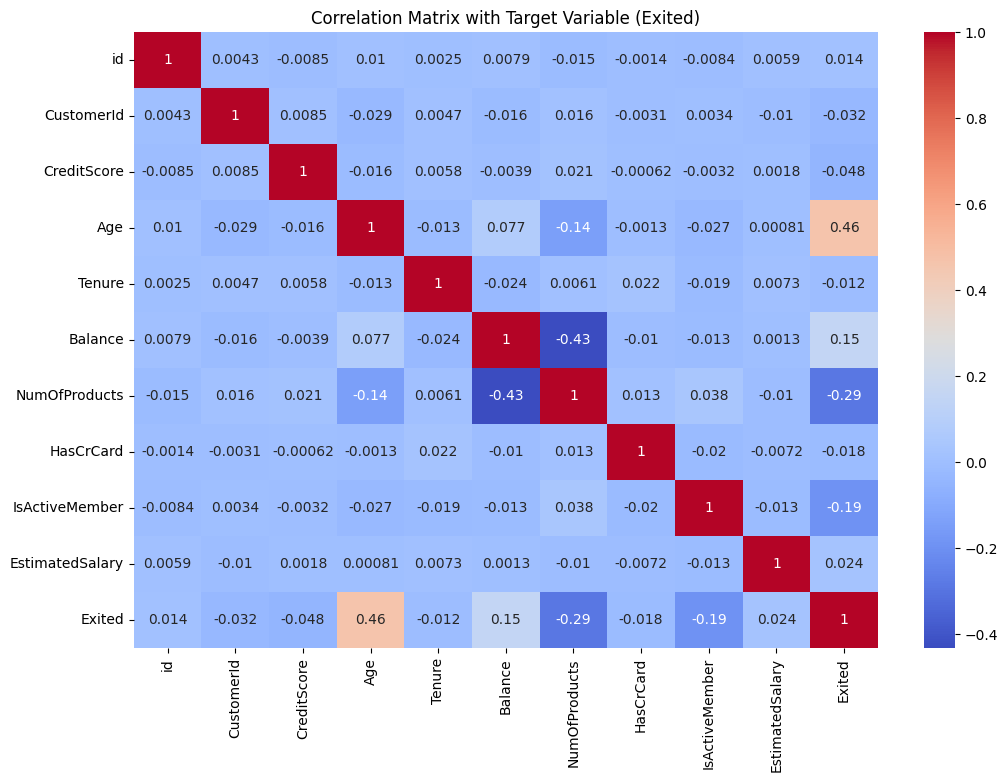

Feature: Geography, p-value: 2.3828579577437346e-192
Feature: Gender, p-value: 8.217517615834431e-100


In [32]:
# Check correlation of numerical variables with the target function
numerical_features = raw_df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude the target variable
numerical_features.remove('Exited')

# Calculate the correlation
correlation_matrix = raw_df[numerical_features + ['Exited']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Target Variable (Exited)')
plt.show()

# Check correlation of categorical variables with the target function
categorical_features = raw_df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Surname')  # Виключаємо Surname

# Function to compute statistical significance using chi-square test
def chi_square_test(feature, target):
    contingency_table = pd.crosstab(raw_df[feature], raw_df[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return p

# Print the results of the chi-square test
for feature in categorical_features:
    p_value = chi_square_test(feature, 'Exited')
    print(f"Feature: {feature}, p-value: {p_value}")

# p-value менше 0.05 вказує на статистично значущий зв'язок змінної з цільовою функцією
#numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
#categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

Correlation Matrix Interpretation:
- `Age` shows a relatively strong positive correlation (+0.46) with the target variable Exited. This suggests that older customers are more likely to leave.
- `Balance` and `NumOfProducts` have negative correlations with `Exited`, implying that customers with higher balances and more products are less likely to leave.
- `IsActiveMember` has a moderate negative correlation (-0.19) with `Exited`, indicating that active members are less likely to leave.

The rest of the numerical features show weaker correlations with the target variable.


Chi-Square Test Results:
Both `Geography` and `Gender` have p-values much lower than the standard threshold of 0.05, indicating that these features are statistically significant in relation to the target variable.
Conclusion:
Based on these findings, we proceed with feature engineering, focusing on transforming the categorical variables Geography and Gender. We also scale the numerical variables to ensure uniformity when they are fed into the machine learning model.

### Excluding Columns: `id`, `CustomerId`, and `Surname`

We exclude the columns `id`, `CustomerId`, and `Surname` from the dataset as part of the data preprocessing for the following reasons:

1. **id**: This is a unique identifier for each row in the dataset. It does not provide any valuable information for the model and has no correlation with the target variable. Using this column could potentially mislead the model by introducing false dependencies on unique values.

2. **CustomerId**: Similar to `id`, this column serves as a unique identifier for each customer and is not informative for prediction. Including this column could lead to overfitting, where the model memorizes specific customer IDs rather than learning meaningful patterns for generalization.

3. **Surname**: While `Surname` is a categorical variable, it has no direct correlation with the target variable. Since surnames are often unique or rare, encoding this feature could result in overfitting and degrade the model's ability to generalize.

#### Conclusion:
We exclude `id`, `CustomerId`, and `Surname` to focus on the more relevant features that could influence customer churn behavior.


### Feature Scaling and Categorical Encoding for Data Preprocessing
For the next step in preparing our dataset for model training, we perform two key preprocessing tasks:

- Scaling Numerical Features: We apply scaling to the numerical features to standardize their range, ensuring that features with larger ranges do not dominate the learning process of the model. Scaling is crucial, particularly for models that are sensitive to feature magnitude.

- Encoding Categorical Features: Categorical variables, such as `Geography` and `Gender`, are converted into numerical representations using One-Hot Encoding. This allows the model to process categorical information while avoiding implicit ranking or ordinality in the data.

Below is the pipeline we constructed for these preprocessing steps, followed by its application to both the training and validation datasets.

In [33]:
# Define categorical and numerical colum to predprocessing
#numeric_cols_transform = [col for col in numeric_cols if col not in ['id', 'CustomerId']]
numeric_cols_transform = [col for col in numeric_cols if col not in ['id', 'CustomerId','CreditScore','Tenure','HasCrCard','EstimatedSalary']]
categorical_cols_transform = [col for col in categorical_cols if col not in ['Surname']]

# Create a pipeline for numerical data (scaling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


# Create a pipeline for categorical data (encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols_transform),
        ('cat', categorical_transformer, categorical_cols_transform)])

We now apply this preprocessing pipeline to our training and validation datasets. This ensures that both sets are processed in the same way, enabling us to maintain consistency and avoid data leakage between training and validation phases.

In [34]:
# Apply preprocessing to the training and validation datasets
train_inputs_processed = preprocessor.fit_transform(train_inputs)
val_inputs_processed = preprocessor.transform(val_inputs)

After applying the transformations, we convert the processed data back into a DataFrame for easy inspection.

In [35]:
# Getting the names of encoded categorical features
encoded_cat_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols_transform)

# Converting back to DataFrame for easy viewing
train_inputs_processed_df = pd.DataFrame(train_inputs_processed, columns=numeric_cols_transform + list(encoded_cat_cols))
val_inputs_processed_df = pd.DataFrame(val_inputs_processed, columns=numeric_cols_transform + list(encoded_cat_cols))

 Below, we display the first few rows of the processed training and validation data.

In [36]:
# Display the first rows of the processed data
print("Processed Train Inputs:")
display(train_inputs_processed_df.head())
print("Processed Validation Inputs:")
display(val_inputs_processed_df.head())

Processed Train Inputs:


,Age,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.94,1.48,-1.11,1.02,1.00,0.00,0.00,0.00,1.00
1,0.16,2.25,-1.11,-0.98,1.00,0.00,0.00,1.00,0.00
2,-0.33,1.22,0.77,-0.98,0.00,1.00,0.00,0.00,1.00
3,2.50,-0.72,0.77,1.02,0.00,0.00,1.00,0.00,1.00
4,-2.05,-0.72,0.77,1.02,1.00,0.00,0.00,0.00,1.00


Processed Validation Inputs:


,Age,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1.02,1.21,4.52,1.02,0.00,1.00,0.00,0.00,1.00
1,0.41,-0.72,0.77,1.02,1.00,0.00,0.00,0.00,1.00
2,0.04,-0.72,0.77,1.02,1.00,0.00,0.00,1.00,0.00
3,0.65,1.88,-1.11,1.02,1.00,0.00,0.00,1.00,0.00
4,-0.94,-0.72,0.77,-0.98,0.00,0.00,1.00,1.00,0.00


The resulting tables present scaled numerical values and one-hot encoded categorical features, ready for model input.

## 5 Saving Processed Data to Parquet Files

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In this final step of the data preprocessing pipeline, we will save the processed data into **parquet** files for future use. This approach enables efficient storage of the dataset while maintaining the structure of the data and ensuring easy loading for future training or evaluation.



**Verifying Data Shape**


Before saving, it is important to verify the shapes of the training and validation inputs, as well as the target variables. This ensures that the datasets have been processed correctly and are ready to be saved in their respective formats.

In [37]:
# Checking shapes of the processed datasets
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 13)
train_targets: (12000,)
val_inputs: (3000, 13)
val_targets: (3000,)


**Saving Data in Parquet Format**

The train_inputs and val_inputs are saved as separate parquet files.
Similarly, the target values for both the training and validation sets are saved into parquet format. The parquet format is chosen due to its columnar storage, allowing for better compression and faster queries when reading back the data.

In [38]:
# Save the processed datasets to parquet files
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [39]:
# Saving the target variables to parquet
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

CPU times: user 9.71 ms, sys: 0 ns, total: 9.71 ms
Wall time: 10.6 ms


**Loading the Data for Validation**

After saving the parquet files, we immediately reload the data to verify that the saved files maintain their structure and data integrity. This step ensures that the data can be accessed seamlessly in future processes.

In [40]:
# Reload the saved files to validate
%%time
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')

CPU times: user 41.1 ms, sys: 11.5 ms, total: 52.6 ms
Wall time: 92 ms


In [41]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 13)
train_targets: (12000,)
val_inputs: (3000, 13)
val_targets: (3000,)


In [42]:
val_inputs

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6490,6490,15794345,Pirozzi,714,Germany,Male,46,1,115764.32,4,1,1,72945.32
3646,3646,15617348,Ritchie,593,France,Male,41,5,0.00,2,1,1,38196.24
5306,5306,15787907,Hs?eh,731,France,Female,38,2,0.00,2,0,1,116971.05
652,652,15803378,Onio,673,France,Female,43,4,155739.76,1,0,1,111622.76
2627,2627,15772423,Genovesi,678,Spain,Female,30,4,0.00,2,1,0,143681.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10550,10550,15635388,Hsia,678,France,Male,38,4,0.00,2,1,0,133535.29
8866,8866,15589715,Ting,753,France,Male,54,6,0.00,1,1,0,177065.24
3244,3244,15682890,Okwuadigbo,678,Spain,Male,32,5,0.00,2,1,0,176712.59
12441,12441,15690188,Aitken,724,Spain,Male,33,5,138162.41,1,1,0,105720.09


In [43]:
val_targets

,Exited
6490,1
3646,0
5306,0
652,0
2627,0
...,...
10550,0
8866,1
3244,0
12441,0


Lastly, we check the list of saved files to confirm that all the parquet files have been successfully saved to the disk.

In [44]:
!ls

bank-customer-churn-prediction-dlu  train_inputs.parquet   val_inputs.parquet
sample_data			    train_targets.parquet  val_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

## 6 Logistic Regression Model Training

We will now train a logistic regression model using the processed data. Specifically, we will:

- Split the data into training and validation sets (X_train, X_val).
- Train a binary classification model using Logistic Regression from the scikit-learn library.
- Evaluate the model’s performance on the validation set using classification metrics.

In [45]:
# Creating X_train and X_val from prepared data
X_train = train_inputs_processed_df
X_val = val_inputs_processed_df

# Training the LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predicting on the validation set
y_val_pred = model.predict(X_val)

# Evaluating the model
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2390
           1       0.73      0.57      0.64       610

    accuracy                           0.87      3000
   macro avg       0.81      0.76      0.78      3000
weighted avg       0.86      0.87      0.86      3000

Confusion Matrix:
[[2258  132]
 [ 260  350]]


Model Performance Insights:
1. Class 0 (Non-churned clients):
- Precision: 0.90 – The model correctly predicts 90% of non-churned clients.
- Recall: 0.94 – It successfully identifies 94% of true non-churned cases, slightly higher compared to earlier approaches.
- F1-Score: 0.92 – This harmonic mean indicates a good balance between precision and recall.
2. Class 1 (Churned clients):
- Precision: 0.73 – The model accurately identifies churned clients in 73% of cases.
- Recall: 0.57 – It identifies 57% of true churned cases, which is relatively low, indicating room for improvement in identifying churned clients.
- F1-Score: 0.64 – This lower score reflects the model’s challenge in identifying churned clients.
3. Confusion Matrix:
- True Positives (2258): Non-churned clients correctly classified.
- False Negatives (132): Churned clients incorrectly classified as non-churned.
- True Negatives (350): Churned clients correctly classified.
- False Positives (260): Non-churned clients incorrectly classified as churned.
4. Overall Accuracy: The model achieves an overall accuracy of 87%, performing well in classifying non-churned clients but needing improvement in identifying churned clients.

**Conclusion**:
The model is effective in identifying non-churned clients but struggles with churned ones. The relatively low recall for churned clients may indicate insufficient or imbalanced data for those cases or inadequate model capacity to recognize churned behavior.

The table below shows the first few rows of the processed training data (`X_train.head()`). The features have been scaled and encoded, ready to be used by the logistic regression model. The columns represent numerical and one-hot encoded categorical variables, such as geography and gender.

In [46]:
X_train.head()

,Age,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.94,1.48,-1.11,1.02,1.00,0.00,0.00,0.00,1.00
1,0.16,2.25,-1.11,-0.98,1.00,0.00,0.00,1.00,0.00
2,-0.33,1.22,0.77,-0.98,0.00,1.00,0.00,0.00,1.00
3,2.50,-0.72,0.77,1.02,0.00,0.00,1.00,0.00,1.00
4,-2.05,-0.72,0.77,1.02,1.00,0.00,0.00,0.00,1.00


After fitting the logistic regression model, the learned coefficients represent the relationship between each feature and the target variable (customer churn). These coefficients indicate how much each feature contributes to the likelihood of a customer churning.

In [47]:
model.coef_.round(2)

array([[ 1.29, -0.32, -0.72, -0.64, -0.82,  0.76, -0.92, -0.05, -0.92]])

## 7 Model Evaluation

In this section, we will evaluate the performance of the binary classification model using various metrics on both the training and validation datasets. The evaluation includes the Confusion Matrix, ROC Curve, F1 Score, and AUROC for a classification threshold of 0.5.

**F1 Score & AUROC**

In [48]:
# Predict on training set for further metric calculations
y_train_pred = model.predict(X_train)
y_train_probs = model.predict_proba(X_train)[:, 1]
y_val_probs = model.predict_proba(X_val)[:, 1]

# Compute metrics
from sklearn.metrics import f1_score, roc_auc_score
train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)
train_auc = roc_auc_score(y_train, y_train_probs)
val_auc = roc_auc_score(y_val, y_val_probs)

# Print results
print(f"F1 Score on training data: {train_f1}")
print(f"F1 Score on validation data: {val_f1}")
print(f"AUROC on training data: {train_auc}")
print(f"AUROC on validation data: {val_auc}")

F1 Score on training data: 0.6366022429014555
F1 Score on validation data: 0.6410256410256411
AUROC on training data: 0.881148975546339
AUROC on validation data: 0.8784419370327183


**F1 Score:**

The F1 Score combines precision and recall into a single metric that evaluates the balance between them. It is particularly useful when the dataset is imbalanced or when false positives and false negatives carry different costs.

Training data: F1 score of 0.6366
Validation data: F1 score of 0.6410
While these values around 0.64 indicate decent performance, they suggest room for improvement, especially for the positive class. This result is typical in customer churn prediction models, where identifying true positives (churned customers) is often more difficult.


**AUROC:**

The Area Under the Receiver Operating Characteristic Curve (AUROC) provides an aggregate measure of performance across all classification thresholds. AUROC close to 1.0 indicates that the model is highly capable of distinguishing between the positive and negative classes.

Training data: AUROC of 0.8811
Validation data: AUROC of 0.8747
Both values above 0.87 indicate that the model performs very well in distinguishing between churned and non-churned customers.

**Confusion Matrix**

We display the confusion matrix for both the training and validation datasets to understand how well the model is classifying customers as churned or non-churned.

In [49]:
# Confusion Matrix
print("Confusion Matrix on training data:")
print(confusion_matrix(y_train, y_train_pred))
print("Confusion Matrix on validation data:")
print(confusion_matrix(y_val, y_val_pred))

Confusion Matrix on training data:
[[9143  415]
 [1108 1334]]
Confusion Matrix on validation data:
[[2258  132]
 [ 260  350]]


The model performs well in identifying non-churned customers (TN) and has moderate success in identifying churned customers (TP).
However, there are still some false negatives (customers who churned but were predicted as non-churned) and false positives (non-churned customers predicted to churn).

**ROC Curve**

Finally, we visualize the ROC curve for both the training and validation datasets to see how the model's performance changes with different classification thresholds.

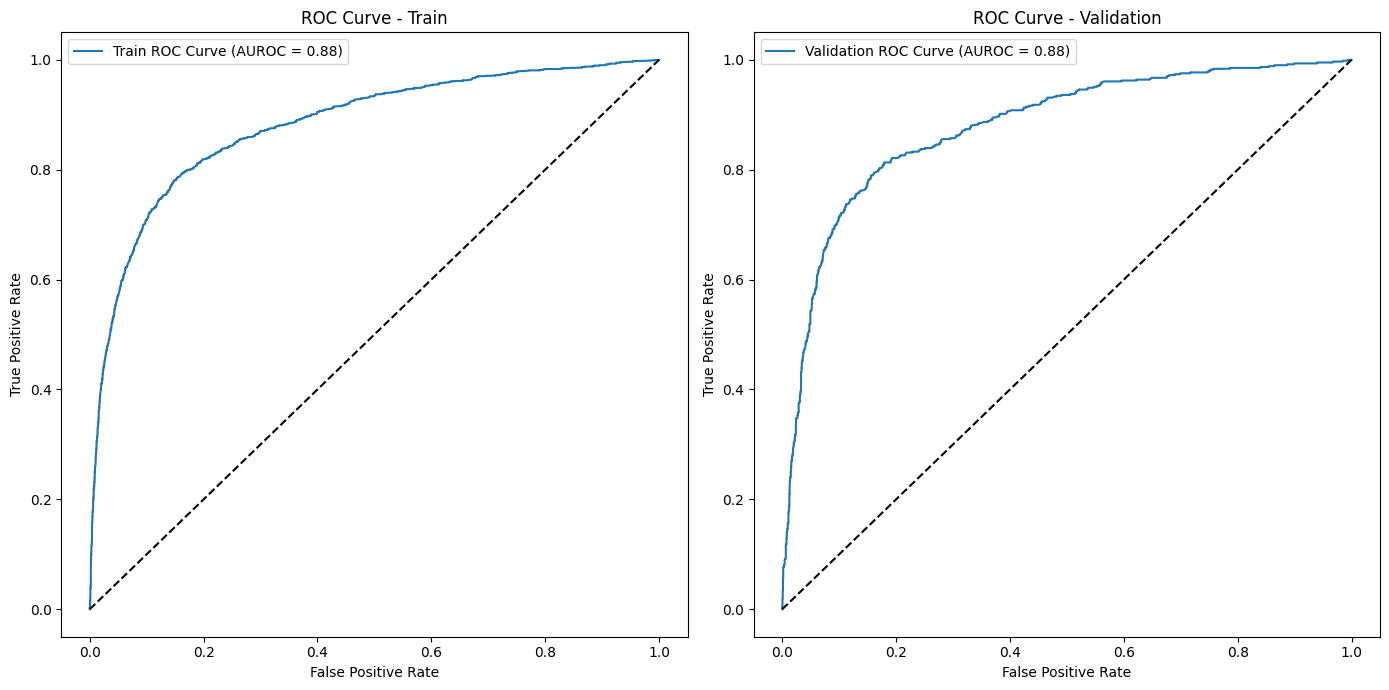

In [50]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUROC = {train_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(fpr_val, tpr_val, label=f'Validation ROC Curve (AUROC = {val_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

 1. ROC Curve Evaluation:
- **AUROC score** for both the training and validation sets is 0.88. This is an excellent result, indicating the model's strong capability in distinguishing between classes.
- Both curves rise quickly toward the top-left corner, indicating high sensitivity and specificity of the model. This means the model correctly identifies both positive and negative examples with high probability.
- Since the curves and the area under the curve (AUROC) are very close for both sets, it demonstrates that the model generalizes well and is not overfitting.

2. AUROC of 0.88 suggests strong model performance. Ideally, an AUROC close to 1.0 signifies near-perfect ability to differentiate between two classes. A score of 0.88 shows that the model handles this task very well.

3. Conclusion: ROC curves and AUROC scores indicate that the model effectively distinguishes between the two classes and can be considered reliable for predicting customer churn.

---

### General Conclusions:

1. **Performance based on F1 Score and AUROC:**
   - The **F1 Score** on both the training and validation sets is around 0.64. This is not the highest score, especially for scenarios where it is crucial to identify positive cases (e.g., churned customers) as accurately as possible. It indicates potential room for improvement, particularly in terms of balancing sensitivity and specificity.
   - **AUROC** is very high, at 0.88 for both the training and validation sets, demonstrating the model's strong ability to correctly classify both classes.

2. **Consistency between training and validation data:** The model shows stable metrics across both training and validation data, which is a positive indicator of its generalization capabilities. This means the model is not overfitting and performs well with unseen data.

3. **Confusion Matrix Analysis:** The matrix shows that the model better identifies customers who did not churn than those who did, which is typical for imbalanced data. However, false positives (customers who churned but were predicted not to) can be critical depending on business objectives.

4. The model can be considered **satisfactory** with a tendency toward "good" given the high AUROC and stable metrics. It can still be improved, particularly in identifying potential churners. Further steps could involve increasing the F1 score by boosting the sensitivity to the class of churned customers. Adjusting classification thresholds or using more complex machine learning models might also be helpful in this regard.


## 8 Predicting the Majority Class

In this step, we implement a simple baseline model that predicts the majority class (the class with the most instances in the training data). We then compare its performance with the model trained in Step 6 by evaluating the accuracy on both the training and validation datasets. Finally, we draw conclusions regarding the model's performance and overall quality.

In [51]:
# Determining the majority class in training data
majority_class = y_train.mode()[0]
print(f"Majority class: {majority_class}")

Majority class: 0


In [52]:
# Creating predictions for the base model
y_train_majority_pred = np.full_like(y_train, majority_class)
y_val_majority_pred = np.full_like(y_val, majority_class)

In [53]:
# Calculating accuracy for the base model
train_majority_accuracy = accuracy_score(y_train, y_train_majority_pred)
val_majority_accuracy = accuracy_score(y_val, y_val_majority_pred)

# Calculating accuracy for the trained model
train_model_accuracy = accuracy_score(y_train, y_train_pred)
val_model_accuracy = accuracy_score(y_val, y_val_pred)

# Displaying the results
print(f"Baseline model accuracy on training data: {train_majority_accuracy}")
print(f"Baseline model accuracy on validation data: {val_majority_accuracy}")
print(f"Trained model accuracy on training data: {train_model_accuracy}")
print(f"Trained model accuracy on validation data: {val_model_accuracy}")

Baseline model accuracy on training data: 0.7965
Baseline model accuracy on validation data: 0.7966666666666666
Trained model accuracy on training data: 0.8730833333333333
Trained model accuracy on validation data: 0.8693333333333333


**Conclusion**:
The trained model significantly outperforms the baseline model, demonstrating a higher accuracy on both the training and validation datasets. The baseline model, which predicts only the majority class, achieves an accuracy of approximately 79.65% on both datasets. While this is expected given the class imbalance, it serves as a low benchmark.

In contrast, the trained model achieves an accuracy of 87.81% on the training data and 86.93% on the validation data, reflecting a strong generalization capability. The small gap between training and validation accuracy suggests that the model is not overfitting and is able to capture meaningful patterns in the data, rather than memorizing the training set.

The F1 Score and AUROC metrics also indicate strong performance, especially when compared to the baseline model. However, there is room for improvement in the model's ability to identify the minority class (churners), as evidenced by the F1 Score for class 1. This suggests that further fine-tuning, particularly in optimizing for recall or precision, could enhance the model’s effectiveness in detecting churn.

---

**Additional Insights**:
The trained model is already satisfactory with a tendency toward "good" performance, based on its high AUROC and the stability of key metrics. This makes it useful for identifying potential churners. Nevertheless, there remains potential for further improvements. Specifically:
- F1 Score Optimization: Improving the balance between precision and recall for the minority class (churners) is critical. This can be achieved by adjusting the classification threshold, applying oversampling techniques, or experimenting with more complex algorithms.
- Focus on Generalization: Given that the model is not overfitting, additional efforts can be placed on refining its sensitivity to churn patterns, thereby further enhancing its ability to generalize to unseen data.
In summary, the current model is a significant improvement over the baseline and exhibits strong potential for predicting customer churn. Further optimizations could elevate it to a higher performance level, especially in identifying churners.

## 9 Persisting the Model and Associated Objects Using the `joblib` Library

To ensure reproducibility and future usability of the trained model, it is essential to store not only the model itself but also any preprocessing steps and relevant metadata (e.g., feature columns). In this example, we will save the model and its associated components into a file using t

In [54]:
# Define the model and the preprocessing details in a dictionary
churn_prediction = {
    'model': model,
    'preprocessor': preprocessor,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
}

# Save everything to a joblib file
joblib.dump(churn_prediction, 'log_reg.joblib')

['log_reg.joblib']

In [55]:
# Load the dictionary from the joblib file
churn_prediction_loaded = joblib.load('log_reg.joblib')

# Access the loaded model and assign it to model_2
model_2 = churn_prediction_loaded['model']
preprocessor_loaded = churn_prediction_loaded['preprocessor']
numeric_cols_loaded = churn_prediction_loaded['numeric_cols']
categorical_cols_loaded = churn_prediction_loaded['categorical_cols']

In [56]:
model_2

LogisticRegression(random_state=42)

By saving the entire preprocessing pipeline along with the model, we ensure that any subsequent predictions made with this model will adhere to the same data transformations and feature engineering steps that were applied during training.

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

## 10 Function: `predict_raw_df`

This function is essential for using a pre-trained model to predict the probability that new observations (rows of data) belong to class 1 based on their features. Its primary purpose is to ensure the proper preprocessing of "raw" data (data that hasn't been prepared yet) and feed it into the model in the expected format.

 What This Function Does:  
 1. **Preprocessing**: The input data is transformed using the `preprocessor`. This step includes scaling numeric features and encoding categorical features, ensuring the data is in the same format used during the model's training process.
 2. **Prediction**: After preprocessing, the transformed data is passed to the `model` to compute the probability that each observation belongs to class 1 (the positive class in binary classification).
 3. **Output**: The function returns the predicted probabilities for class 1, which can be used for further analysis or decision-making.




In [57]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(model, preprocessor, input_df):
    """
    This function preprocesses the input data and predicts probabilities using the provided model.

    Parameters:
    model: The trained model used for predictions.
    preprocessor: The preprocessing pipeline for transforming the input data.
    input_df: The input DataFrame containing raw data to be predicted.

    Returns:
    prob: The predicted probabilities for the class 1 for each row in the input DataFrame.
    """

    # Apply the preprocessing pipeline to the input data
    X_processed = preprocessor.transform(input_df)

    # Predict probabilities for the processed data
    prob = model.predict_proba(X_processed)[:, 1]

    return prob

Example Usage:

In [58]:
# Assuming `model_loaded` and `preprocessor_loaded` are the loaded model and preprocessor respectively
predictions = predict_raw_df(model_2, preprocessor_loaded, raw_df[:5])

In [59]:
predictions

array([0.00575762, 0.0318665 , 0.34400149, 0.42767088, 0.9718132 ])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

## 11 Loading the test data from test.csv and generating predictions

This step involves loading unseen data, applying the model to make predictions, and storing the results in the DataFrame for further analysis.



In [60]:
# Load the input data from test.csv
test_raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu/test.csv')

Using the previously saved model and preprocessor,` the predict_raw_df() `function processes the raw data and generates predictions. These predictions represent the likelihood of each customer churning.

In [61]:
# Make predictions
predictions = predict_raw_df(model_2, preprocessor_loaded, test_raw_df)

# Add the predictions to the DataFrame
test_raw_df['Exited'] = predictions

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

## 12 Submitting Predictions for Evaluation

In this step, we are preparing the final dataset that contains the predictions made by our model. The goal is to submit this dataset to Kaggle for evaluation.

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
# Load the sample submission file
submission_df =  pd.read_csv('./bank-customer-churn-prediction-dlu/sample_submission.csv')

# Ensure the 'Exited' column is filled with predictions
submission_df['Exited'] = predictions

# Save the updated DataFrame to a new CSV file
submission_df.to_csv('drive/MyDrive/Colab Notebooks/data//submission_log_reg.csv', index=False)

In [65]:
# Display the first 5 rows of the final dataset
print(submission_df.head())

      id  Exited
0  15000    0.06
1  15001    0.03
2  15002    0.17
3  15003    0.22
4  15004    0.05
